**este notebook irá avaliar o modelo treinado**

## prompts



> prompt 5: escreva como fazer esses gráficos: gráficos de resíduos, gráficos de erros preditivos

> prompt 6: how can I get the features of the 11 columns here as now is an array X_processed = preprocessor.fit_transform(X)





# Bibliotecas

In [ ]:
!pip install pymysql

In [2]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#mount drive
from google.colab import drive
drive.mount('/content/drive')

import pickle

Mounted at /content/drive


#Conexão com MySQL

In [3]:
# Dados de conexão
host = '185.213.26.130'
port = 6033
user = 'case_data_scientist'
password = 'UPDf/24bPQp8JuHC'
database = 'case_data_scientist'

# Conectando
conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# Listar tabelas disponíveis
cursor = conn.cursor()
cursor.execute("SHOW TABLES;")
tabelas = cursor.fetchall()
print("Tabelas disponíveis no banco de dados:")
for t in tabelas:
    print("-", t[0])

Tabelas disponíveis no banco de dados:
- daumau
- desinstalacoes
- installs
- ratings_reviews


# Tratamento das tabelas

Iremos repetir o tratamento utilizado no notebook 1 e a separação no 2

## transformando em DFs

In [4]:
# Lista de tabelas que queremos carregar
tabelas = ['daumau', 'desinstalacoes', 'installs', 'ratings_reviews']

# Dicionário para armazenar os DataFrames
dfs = {}

# Loop para carregar cada tabela
for tabela in tabelas:
    df = pd.read_sql(f"SELECT * FROM {tabela}", conn)
    dfs[tabela] = df
    print(f"Tabela '{tabela}' carregada com shape: {df.shape}")

# Fecha a conexão
conn.close()

<ipython-input-4-2724695920>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {tabela}", conn)


Tabela 'daumau' carregada com shape: (41299, 4)
Tabela 'desinstalacoes' carregada com shape: (53188, 5)
Tabela 'installs' carregada com shape: (48150, 3)
Tabela 'ratings_reviews' carregada com shape: (47155, 7)


## tratando colunas

In [5]:
df_daumau = dfs['daumau']
df_desinstalacoes = dfs['desinstalacoes']
df_installs = dfs['installs']
df_ratings_reviews = dfs['ratings_reviews']

In [6]:
#converter datas de df_daumau e df_ratings_reviews em datetime64[ns]
df_daumau['date'] = pd.to_datetime(df_daumau['date'])
df_ratings_reviews['date'] = pd.to_datetime(df_ratings_reviews['date'])

#filtrar dados depois de 2025-06-11
date_threshold = pd.to_datetime('2025-06-11')
df_daumau = df_daumau[df_daumau['date'] <= date_threshold]

#remover colunas country e lang de df_desinstalacoes
df_desinstalacoes = df_desinstalacoes.drop(columns=['country', 'lang'])

#remover mauReal de df_daumau
df_daumau = df_daumau.drop(columns=['mauReal'])

#renomeando colunas de 'appid' para 'appId'
df_installs = df_installs.rename(columns={'appid': 'appId'})
df_ratings_reviews = df_ratings_reviews.rename(columns={'appid': 'appId'})

# remover duplicados em appId e date de todos
df_daumau = df_daumau.drop_duplicates(subset=['appId', 'date'])
df_desinstalacoes = df_desinstalacoes.drop_duplicates(subset=['appId', 'date'])
df_installs = df_installs.drop_duplicates(subset=['appId', 'date'])
df_ratings_reviews = df_ratings_reviews.drop_duplicates(subset=['appId', 'date'])

#resetar o index de todos
df_daumau = df_daumau.reset_index(drop=True)
df_desinstalacoes = df_desinstalacoes.reset_index(drop=True)
df_installs = df_installs.reset_index(drop=True)
df_ratings_reviews = df_ratings_reviews.reset_index(drop=True)

#remover nulos em daumau
df_daumau = df_daumau.dropna()

#resetar_index
df_daumau = df_daumau.reset_index(drop=True)

## fazendo merge

In [7]:
merged_df = df_daumau.merge(df_desinstalacoes, on=['appId', 'date'], how='left')
merged_df = merged_df.merge(df_installs, on=['appId', 'date'], how='left')
merged_df = merged_df.merge(df_ratings_reviews, on=['appId', 'date'], how='left')

#ordenar por data
merged_df = merged_df.sort_values(by='date')

#resetar o index
merged_df = merged_df.reset_index(drop=True)

#remover todos com data anterior a 2008-07-10 (criação da app store)
merged_df = merged_df[merged_df['date'] >= '2008-07-10']

#resetar o index
merged_df = merged_df.reset_index(drop=True)

#preencher nulos em category como 'DESCONHECIDO'
merged_df['category'] = merged_df['category'].fillna('DESCONHECIDO')

#preencher todoas as numéricas com 0
numericas = ['predictionLoss', 'newinstalls', 'ratings', 'daily_ratings', 'reviews', 'daily_reviews']
merged_df[numericas] = merged_df[numericas].fillna(0)

# separando para validação

In [8]:
#filtrando os com data maior ou igual a 25 de julho (2024-07-25)
df_validacao = merged_df[merged_df['date'] >= '2024-07-25'].reset_index(drop=True)
df_validacao

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.79754,2024-07-25,9883.0,8907.0,708.0,OTHERS,129347.0,122.0,8825.0,13.0
1,com.app.91390,2024-07-25,34967.0,15069.0,1547.0,BUSINESS,167814.0,36.0,110636.0,25.0
2,com.app.55537,2024-07-25,7176.0,7378.0,94.0,OTHERS,2797.0,0.0,1466.0,1.0
3,com.app.68942,2024-07-25,257224.0,17312.0,0.0,OTHERS,53445.0,13.0,19600.0,6.0
4,com.app.18664,2024-07-25,8955.0,2377.0,691.0,FINANCE,9050.0,10.0,1644.0,1.0
...,...,...,...,...,...,...,...,...,...,...
10062,com.app.37148,2024-10-01,11618.0,1174.0,149.0,DESCONHECIDO,0.0,0.0,0.0,0.0
10063,com.app.50679,2024-10-01,9683.0,1396.0,382.0,DESCONHECIDO,0.0,0.0,0.0,0.0
10064,com.app.35851,2024-10-01,6419.0,6301.0,270.0,DESCONHECIDO,0.0,0.0,0.0,0.0
10065,com.app.17441,2024-10-01,31452.0,3630.0,836.0,DESCONHECIDO,0.0,0.0,0.0,0.0


# processamento dos dados

iremos processar os dados semelhante ao notebook 2

In [9]:
#remover colunas
X = df_validacao.drop(['appId', 'date', 'dauReal', 'predictionLoss', 'ratings'], axis=1)
y = df_validacao['dauReal']

#separando numéricas e categóricas
categorical_features = ['category']
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

#encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)
X_processed.shape

(10067, 11)

# Carregando o modelo

In [10]:
caminho_modelo = '/content/drive/MyDrive/Codes/Rankmyapp/modelo_previsao_dau.pkl'

# Carregando o modelo treinado
with open(caminho_modelo, 'rb') as f:
    modelo = pickle.load(f)

# Validação

In [35]:
# Fazer as previsões
y_pred = modelo.predict(X_processed)

# Calcular métricas
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

# Exibir os resultados
print('--- Avaliação do Modelo ---')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R²): {r2:.2f}')

--- Avaliação do Modelo ---
Root Mean Squared Error (RMSE): 309492.14
Mean Absolute Error (MAE): 78508.03
R-squared (R²): 0.95


- `R2:` coeficiente de determinação. Percentual da variância dos dados que é explicado pelo modelo
- `MAE:` média da diferença entre o valor real com o predito
- `RMSE:` penalisa as grandes diferenças, quanto muito distante de `MAE`, indica que outliers estão afetando o modelo.

[mais detalhes](https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70)

Vamos ter uma visão gráfica dos resíduos

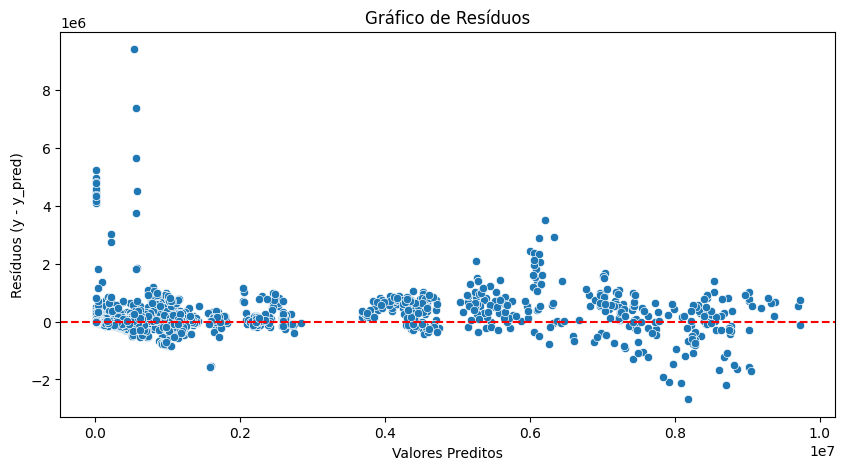

In [12]:
# Calcular resíduos
residuos = y - y_pred

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos (y - y_pred)')
plt.show()

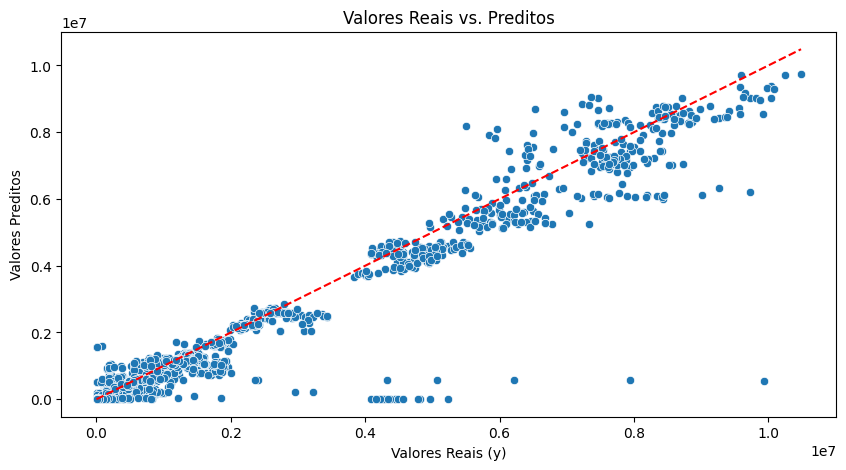

In [13]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Linha 45°
plt.title('Valores Reais vs. Preditos')
plt.xlabel('Valores Reais (y)')
plt.ylabel('Valores Preditos')
plt.show()

R-squared com 95% indica bom desempenho.
RMSE ser muito maior que MAE conclui-se que há alguns erros maiores (outliers). Os erros grandes são provavelmente pela existência de muitos zeros e outliers. A análise gráfica demostra que o modelo segue a maioria da disperção dos dados

Agora vamos indentificar quais variáveis mais influenciam na estimativa do `DAU`:

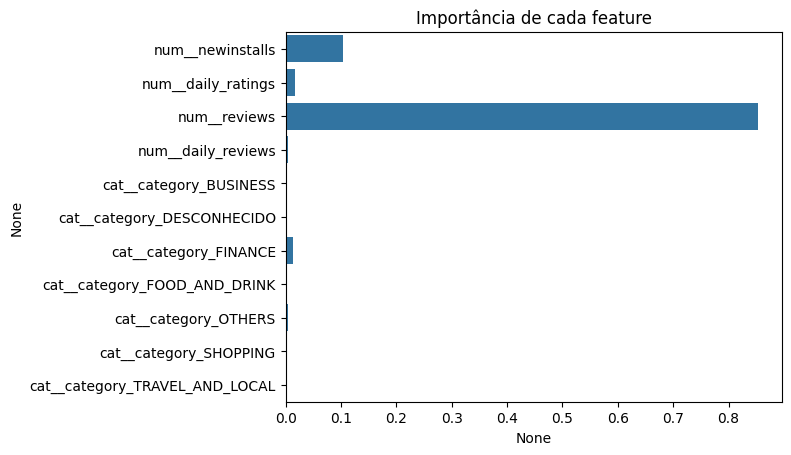

In [28]:
# Mostrando importância de cada feature
feature_names = preprocessor.get_feature_names_out()
importances = pd.Series(data=modelo.feature_importances_, index=feature_names)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature');

Observa-se que o número de reviews determina cerca de 85% DAU neste modelo, e o número de intalações é o 2º mais importante.

# Conclusão

### sobre performance:

Concluimos que modelo precisa passar por melhorias, apesar de apresentar bom desempenho pela métrica do `R2`, os outliers e presença de valores muitos baixos ou zero leva a maiores erros, o que é reportado pela métrica `RMSE`. Pela a análise gráfica, observa-se que o modelo obteve bom ajuste, mas se reforça o melhor tratamento de outliers e de `testes A/B` para que se consiga um desempenho com menores erros.

### sobre melhorias:

Devido ao tempo do case, observei melhorias que precisaria de mais para testá-las. Aqui estão melhorias que devem ser testadas para construção de um modelo melhor:

**Outliers:** aplicar a remoção ou tratamento de outliers como o `quantile_transformer`, aplicando testes A/B

**Seleção de features:** utillizar metodologias de seleção e rankeamento de features como Boruta, e RFE. Úteis para algoritmos ensembles.

**segmentação dos ids dos apps:** uma melhor segmentação dos apps para agregar informação no treinamento sem aumentar muito a dimensionalidade

**Normalização dos dados:** Também pode haver teste com o `Robust Scaler` para a normalização na preparação dos dados, uma vez que ele lida melhor com outliers

**Remoção de nulos:** remover linha com muitos valores nulos da base montada na coleta dos dados, e realizar testes A/B de performance

**Tunamento:** aplicação de ajustes nos hiperparâmetros do modelo